# AI-Driven Disease Risk Stratification: Tackling the Challenge of Complex Confounders to Enable Precision-Medicine

**Authors**: S. Momsen Reincke, Camilo Espinosa, Philip Chung, Tomin James, Eloïse Berson, Nima Aghaeepour

## Introduction

This Jupyter Notebook accompanies the paper "AI-Driven Disease Risk Stratification: Tackling the Challenge of Complex Confounders to Enable Precision-Medicine." In this paper, we address the critical challenges posed by complex confounders in disease prediction using Artificial Intelligence (AI) models based on electronic health record (EHR) data. This notebook contains all the code and analyses to run the clinical simulation experiment. Additionally, we provide the models and results that were used to generate the dataset in Figure 1 and Extended Data Figure 2.

### Notebook Overview

This notebook is structured as follows:

- **Section 1: Dataset Generation, Model Training, and Evaluation**
  - This section covers the code for generating the simulated clinical dataset, implementing the single-outcome multi-class prediction model, and evaluating its performance. 
  
- **Section 2: Training and Saving the Model**
  - Here, we provide the code to train the model on the generated dataset and details on how to save the trained model for future validation.
  
- **Section 3: Figure Generation**
  - This section focuses on creating the visualizations for Figure 1 and Extended Data Fig. 2 as described in our paper. We load the results of our trained models and create the plots shown in the publication.

## Requirements

To run this notebook, ensure that you have the following packages installed:
- python (3.11)
- pytorch (2.0.0)
- cudatoolkit (11.8)
- numpy
- matplotlib
- seaborn
- torch
- sklearn
- scipy
- pickle
- scikit-learn


These packages can be installed via pip or conda. For example, to install all dependencies with conda, you can use:

```bash
conda env create -f environment.yml
conda activate clinical_simulation
```

After this, start a jupyter notebook session and run this notebook.

## Code to run the clinical simulation experiment

#### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics._ranking import _binary_clf_curve
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer, AvgPool1d
import scipy
from sklearn.metrics import confusion_matrix
import seaborn as sns

from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

import datetime
import gzip

### Section 1: Code for dataset generation, model traimplementation, and model evaluation

In [6]:
def prepare_transformer_dataset_v3(num_samples = 100000, \
                                sequence_length = 1, \
                                num_features_per_type = 10, \
                                num_random_features = 100, \
                                correlation_factors = np.arange(0.1, 1, 0.1),
                                alpha=1, beta =1, 
                                labeling_method='multilabel',
                                random_distribution='normal',
                                noise=0.7,
                                hardcoded_thresholds=True,
                                quantile=0.99):
    """
    Prepare datasets for transformer models with synthetic data generation involving correlations.
    
    Args:
        num_samples (int): Number of samples to generate.
        sequence_length (int): Length of sequence for each sample.
        num_features_per_type (int): Number of features for each type.
        num_random_features (int): Number of random features.
        correlation_factors (array): Array of correlation factors to apply between features.
        alpha (float): Coefficient for feature A in risk calculation.
        beta (float): Coefficient for feature B in risk calculation.
        labeling_method (str): Method used for labeling the data.
        random_distribution (str): Type of distribution to use for generating random features.
        noise (float): Noise level to add to the features.
        hardcoded_thresholds (bool): Whether to use hardcoded thresholds for binary classification.
        quantile (float): Quantile used for threshold calculation if hardcoded_thresholds is False.
    
    Returns:
        tuple: Tuple containing:
            - datasets (list): A list of datasets, each a dictionary with train, dev, and test splits.
            - num_classes (int): Number of classes, depending on the labeling method.
    """
    datasets = []

    prevalences=[]
    prevalences_test=[]
    
    thresholds_hardcoded = {
        0: 0.97,
        0.1: 0.925,
        0.2: 0.9,
        0.3: 0.885,
        0.4: 0.876,
        0.5: 0.872,
        0.6: 0.873,
        0.7: 0.879,
        0.8: 0.892,
        0.9: 0.913,
        1: 0.94
    }

    for factor in correlation_factors:
        longitudinal_data = np.zeros((num_samples, sequence_length, num_random_features + 3 * num_features_per_type))
        longitudinal_labels = np.zeros(num_samples)
        
        # Generate core variable A,B,C and random features for this time point
        if(random_distribution=='normal'):
            random=np.random.randn
        elif(random_distribution=='uniform'):
            random=np.random.rand

        C = random(num_samples)
        A = random(num_samples)
        B = random(num_samples)

        for t in range(sequence_length):

            random_features = random(num_samples, num_random_features)

            # Generate C-features
            C_features = (1-noise) * np.tile(C, (num_features_per_type, 1)).T + (noise) * random(num_samples, num_features_per_type)
            A_features = (1-noise) * np.tile(A, (num_features_per_type, 1)).T + (noise)*random(num_samples, num_features_per_type)
            B_features = (1-noise) * np.tile(B, (num_features_per_type, 1)).T + (noise)*random(num_samples, num_features_per_type)
      
            # Combine all features for this time point
            #longitudinal_data[:, t, :] = np.hstack((C_features, A_features, B_features))
            longitudinal_data[:, t, :] = np.hstack((random_features, C_features, A_features, B_features))
        
        # Step 1: Generate random sequence lengths for each sample, broadcast compare to create the binary mask
        # The mask will have a shape of (num_samples, sequence_length)
        random_lengths = np.random.randint(1, sequence_length + 1, size=num_samples)
        range_array = np.arange(sequence_length)
        binary_mask = range_array < random_lengths[:, None]

        risk_1=alpha*((1-factor)*A)+factor*C
        risk_2=beta*((1-factor)*B)+factor*C
        if(hardcoded_thresholds==True):
            if(quantile==0.97):
                threshold_1=threshold_2=thresholds_hardcoded[round(factor,1)]
            else:
                print('hardcoded thresholds only available for quantile 0.97')
                threshold_1 = np.quantile(risk_1, quantile, method='lower')
                threshold_2 = np.quantile(risk_2, quantile, method='lower')
        else:
            threshold_1 = np.quantile(risk_1, quantile, method='lower')
            threshold_2 = np.quantile(risk_2, quantile, method='lower')
        
        labels = np.zeros_like(A, dtype=int)

        if(labeling_method=='multilabel_hybrid'):  
            labels[(risk_1 > threshold_1) ] = 1
            labels[(risk_2 > threshold_2) ] = 2
            labels[(risk_1 > threshold_1) & (risk_2 > threshold_2)] = 3     

            #count how many samples have label 3
            indices_label_3 = np.where(labels == 3)[0]
            half_point = len(indices_label_3) // 2  # Find the halfway point (integer division for even split)

            labels[indices_label_3[:half_point]] = 1
            labels[indices_label_3[half_point:]] = 2

            num_classes = 3  # Adjust the number of classes if needed
        else:
            print('labeling method not recognized.')

        longitudinal_labels = labels

        # Splitting data into train, dev, and test sets
        X_temp, X_test, y_temp, y_test, binary_mask_temp, binary_mask_test   = train_test_split(longitudinal_data, longitudinal_labels, binary_mask, test_size=0.2, random_state=50)
        X_train, X_dev, y_train, y_dev, binary_mask_train, binary_mask_dev = train_test_split(X_temp, y_temp, binary_mask_temp, test_size=0.125, random_state=50)  # 0.125 * 0.8 = 0.1
        
        #report prevalence of each class in test set
        prevalence = np.array([np.sum(labels==0)/len(labels), np.sum(labels==1)/len(labels), np.sum(labels==2)/len(labels)])
        prevalence_test = np.array([np.sum(y_test==0)/len(y_test), np.sum(y_test==1)/len(y_test), np.sum(y_test==2)/len(y_test)])

        prevalences.append(prevalence)
        prevalences_test.append(prevalence_test)

        # Store in the datasets list
        datasets.append({
            'factor': factor,
            'prevalence': prevalence,
            'prevalence_test': prevalence_test,
            'X_train': X_train, 'X_dev': X_dev, 'X_test': X_test,
            'y_train': y_train, 'y_dev': y_dev, 'y_test': y_test,
            'binary_mask_train': binary_mask_train, 'binary_mask_dev': binary_mask_dev, 'binary_mask_test': binary_mask_test
        })

    return datasets, num_classes

def get_at_risk_RR(golds_for_eval, probs_for_eval):
    """
    Calculate the at-risk population and relative risk ratios based on model predictions.
    
    Args:
        golds_for_eval (array-like): Ground truth (binary labels).
        probs_for_eval (array-like): Predicted probabilities from the model.
    
    Returns:
        tuple: Tuple containing:
            - at_risk (numpy.ndarray): The at-risk population per 1,000,000 samples.
            - RR (numpy.ndarray): Relative risk ratio compared to the incidence.
    """ 
    incidence_ratio=np.sum(golds_for_eval)/len(golds_for_eval)
    fps, tps, _ = _binary_clf_curve(golds_for_eval, probs_for_eval, pos_label=1)
    positives=fps+tps
    precisions_from_binary_clf=tps/positives
    at_risk=positives*1000000/len(golds_for_eval)
    RR=np.divide(precisions_from_binary_clf,incidence_ratio)
    return at_risk, RR

def init_metrics_dict():
    """
    Initialize a dictionary to hold metric values for evaluating model performance.
    
    Returns:
        dict: A dictionary with keys for various metrics, each initialized to an empty list.
    """
    metrics = {
        'auroc': [],
        'auprc': [],
        'precision': [],
        'recall': [],
        'at_risk': [],
        'RR': [],
        'TNR': [],
        'TPR': [],
        'PPV': [],
        'NPV': [],

        'F1': [],
        'gold_labels': [],
        'probabilities': []
    }
    return metrics


def run_multiclass_transformer_model_and_calculate_metrics(dataset,model, metrics, cross_metrics, num_classes=4, \
                                                           num_output_time_points=1, combined_metrics =None, combined_cross_metrics = None, random_sequence_length=True, labeling_method='multilabel'):  
    """
    Run predictions using a multiclass transformer model and calculate various metrics.
    
    Args:
        dataset (dict): Dataset containing train, dev, and test splits.
        model (torch.nn.Module): PyTorch model to be evaluated.
        metrics (dict): Dictionary to store metrics for each class.
        cross_metrics (dict): Dictionary to store cross-evaluation metrics.
        num_classes (int): Number of classes in the model's output.
        num_output_time_points (int): Number of output time points from the model.
        combined_metrics (dict): Dictionary for combined metrics if available.
        combined_cross_metrics (dict): Dictionary for combined cross-evaluation metrics.
        random_sequence_length (bool): Whether to handle varying sequence lengths.
        labeling_method (str): Labeling method used in the dataset.
    """
    test_batch_size=32768
    # Extract the test set
    X_test = dataset['X_test']
    labels_test = dataset['y_test']

    # Convert to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    binary_mask_test_tensor = torch.tensor(dataset['binary_mask_test'], dtype=torch.bool)

    # Create DataLoader without labels
    test_dataset = TensorDataset(X_test_tensor, binary_mask_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    # Ensure model is in evaluation mode to turn off dropout
    model.eval()

    # Initialize a list to store batch-wise probabilities
    all_probabilities = []

    # Predict probabilities for each batch
    with torch.no_grad():
        for batch in test_loader:
            X_batch, binary_mask = batch

            # Forward pass
            model_output = model(X_batch,binary_mask).detach() if random_sequence_length==True else model(X_batch).detach()
            model_output = model_output.view(-1, num_output_time_points, num_classes)

            # Compute probabilities
            probabilities = torch.softmax(model_output, dim=2).cpu().numpy()
            all_probabilities.append(probabilities)

    # Concatenate batch-wise probabilities
    probabilities = np.concatenate(all_probabilities, axis=0)

    #release GPU memory
    del model_output
    del all_probabilities

    for class_idx in range(num_classes):
        # Prepare the true binary labels for the current class
        true_binary_labels = (labels_test == class_idx).astype(int)

        # Flatten the true_binary_labels if it's 2D
        if true_binary_labels.ndim > 1:
            true_binary_labels = true_binary_labels.flatten()

        # Extract and flatten the probability predictions for the current class
        class_probabilities = probabilities[:, :, class_idx]
        if class_probabilities.ndim > 1:
            class_probabilities = class_probabilities.flatten()

        # Ensure the lengths match
        assert len(true_binary_labels) == len(class_probabilities), "Lengths of labels and probabilities do not match."

        metrics[class_idx]['gold_labels'].append(true_binary_labels)
        metrics[class_idx]['probabilities'].append(class_probabilities)

        # Calculate the AUROC for the current class
        metrics[class_idx]['auroc'].append( roc_auc_score(true_binary_labels, class_probabilities))

        # Calculate the precision-recall curve for the current class
        precision, recall, _ = precision_recall_curve(true_binary_labels, class_probabilities)
        metrics[class_idx]['precision'].append(precision)
        metrics[class_idx]['recall'].append(recall)

        # Compute AUPRC
        metrics[class_idx]['auprc'].append(auc(recall, precision))

        # Compute at risk and RR
        at_risk, RR = get_at_risk_RR(true_binary_labels, class_probabilities)
        metrics[class_idx]['at_risk'].append(at_risk)
        metrics[class_idx]['RR'].append(RR)

    del true_binary_labels, class_probabilities, precision, recall

    if(combined_metrics is not None):
        #Compute the 'combined metric' 1+3 vs. 0+2
        # Prepare the true binary labels for the current class
        if(labeling_method=='multilabel_hybrid'):
            true_binary_labels = ((labels_test == 1) ).astype(int)
        else:
            print('labeling method not recognized')
    
        # Flatten the true_binary_labels if it's 2D
        if true_binary_labels.ndim > 1:
            true_binary_labels = true_binary_labels.flatten()

        # Extract and flatten the probability predictions for the current class
        if(labeling_method=='multilabel_hybrid'):
            class_probabilities = probabilities[:, :, 1]
        if class_probabilities.ndim > 1:
            class_probabilities = class_probabilities.flatten()

        # Ensure the lengths match
        assert len(true_binary_labels) == len(class_probabilities), "Lengths of labels and probabilities do not match."

        # Calculate the AUROC for the current class
        combined_metrics[1]['auroc'].append( roc_auc_score(true_binary_labels, class_probabilities))

        # Calculate the precision-recall curve for the current class
        precision, recall, _ = precision_recall_curve(true_binary_labels, class_probabilities)
        combined_metrics[1]['precision'].append(precision)
        combined_metrics[1]['recall'].append(recall)

        # Compute AUPRC
        combined_metrics[1]['auprc'].append(auc(recall, precision))

        # Compute at risk and RR
        at_risk, RR = get_at_risk_RR(true_binary_labels, class_probabilities)
        combined_metrics[1]['at_risk'].append(at_risk)
        combined_metrics[1]['RR'].append(RR)     

    
        del true_binary_labels, class_probabilities, precision, recall

    if(combined_cross_metrics is not None):
        #Compute the 'combined metric' 1+3 vs. 0+2
        # Prepare the true binary labels for the current class
        if(labeling_method=='multilabel_hybrid'):
            true_binary_labels = ((labels_test == 2) ).astype(int)
        else:
            print('labeling method not recognized')

        # Flatten the true_binary_labels if it's 2D
        if true_binary_labels.ndim > 1:
            true_binary_labels = true_binary_labels.flatten()

        # Extract and flatten the probability predictions for the current class
        if(labeling_method=='multilabel_hybrid'):
            class_probabilities = probabilities[:, :, 1]
        if class_probabilities.ndim > 1:
            class_probabilities = class_probabilities.flatten()

        # Ensure the lengths match
        assert len(true_binary_labels) == len(class_probabilities), "Lengths of labels and probabilities do not match."

        # Calculate the AUROC for the current class
        combined_cross_metrics[1]['auroc'].append( roc_auc_score(true_binary_labels, class_probabilities))

        # Calculate the precision-recall curve for the current class
        precision, recall, _ = precision_recall_curve(true_binary_labels, class_probabilities)
        combined_cross_metrics[1]['precision'].append(precision)
        combined_cross_metrics[1]['recall'].append(recall)

        # Compute AUPRC
        combined_cross_metrics[1]['auprc'].append(auc(recall, precision))

        # Compute at risk and RR
        at_risk, RR = get_at_risk_RR(true_binary_labels, class_probabilities)
        combined_cross_metrics[1]['at_risk'].append(at_risk)
        combined_cross_metrics[1]['RR'].append(RR)     

        del true_binary_labels, class_probabilities, precision, recall

    #cross-evaluation
    for class_idx in range(num_classes):
        if(class_idx==1):
            label_index=2
        elif(class_idx==2):
            label_index=1
        else:
            label_index=0

        # Prepare the true binary labels for the current class
        true_binary_labels = (labels_test == label_index).astype(int)

        # Flatten the true_binary_labels if it's 2D
        if true_binary_labels.ndim > 1:
            true_binary_labels = true_binary_labels.flatten()

        # Extract and flatten the probability predictions for the current class
        class_probabilities = probabilities[:, :, class_idx]
        if class_probabilities.ndim > 1:
            class_probabilities = class_probabilities.flatten()

        # Ensure the lengths match
        assert len(true_binary_labels) == len(class_probabilities), "Lengths of labels and probabilities do not match."

        # Calculate the AUROC for the current class
        cross_metrics[class_idx]['auroc'].append(roc_auc_score(true_binary_labels, class_probabilities))
        
        # Calculate the precision-recall curve for the current class
        precision, recall, _ = precision_recall_curve(true_binary_labels, class_probabilities)
        cross_metrics[class_idx]['precision'].append( precision)
        cross_metrics[class_idx]['recall'].append( recall)

        # Compute AUPRC
        cross_metrics[class_idx]['auprc'].append( auc(recall, precision))

        # Compute at risk and RR
        at_risk, RR = get_at_risk_RR(true_binary_labels, class_probabilities)
        cross_metrics[class_idx]['at_risk'].append(at_risk)
        cross_metrics[class_idx]['RR'].append(RR)


def run_binary_transformer_model_and_calculate_metrics(dataset,model,metrics,cross_metrics, random_sequence_length=True):
    """
    Evaluate a single-outcome transformer model and compute metrics.
    
    Args:
        dataset (dict): Dataset containing test set and binary masks.
        model (torch.nn.Module): Model to be evaluated.
        metrics (dict): Dictionary to store metrics for binary classification.
        cross_metrics (dict): Dictionary to store metrics for cross-evaluation.
        random_sequence_length (bool): Whether sequence length varies within the dataset.
    """
    test_batch_size = 32768
    # Convert to PyTorch tensors
    X_test_tensor = torch.tensor(dataset['X_test'], dtype=torch.float32)
    binary_mask_test_tensor = torch.tensor(dataset['binary_mask_test'], dtype=torch.bool)
    test_dataset = TensorDataset(X_test_tensor, binary_mask_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    y_test_A=(dataset['y_test']==1).astype(int)
    y_test_B=(dataset['y_test']==2).astype(int)
    

    #make sure model is not using dropout
    model.eval()

    all_probabilities = []

    with torch.no_grad():
        for batch in test_loader:
            X_batch,binary_mask = batch
            model_output= model(X_batch,binary_mask) if random_sequence_length==True else model(X_batch)

            probabilities = nn.Sigmoid()(model_output).detach().cpu().numpy()
            all_probabilities.append(probabilities)

    probabilities = np.concatenate(all_probabilities, axis=0)
    
    #release GPU memory
    del X_test_tensor
    del model_output

    metrics[0]['gold_labels'].append(y_test_A)
    metrics[0]['probabilities'].append(probabilities)
    metrics[1]['gold_labels'].append(y_test_B)

    # Calculate AUROC for A
    metrics[0]['auroc'].append(roc_auc_score(y_test_A, probabilities))
    
    # Calculate precision-recall curve for A
    precision_A, recall_A, _ = precision_recall_curve(y_test_A, probabilities)
    metrics[0]['auprc'].append(auc(recall_A, precision_A))

    at_risk_A,RR_A=get_at_risk_RR(y_test_A, probabilities)

    # Calculate AUROC for B
    cross_metrics[0]['auroc'].append(roc_auc_score(y_test_B, probabilities))

    # Calculate precision-recall curve for B
    precision_B, recall_B, _ = precision_recall_curve(y_test_B, probabilities)
    cross_metrics[0]['auprc'].append(auc(recall_B, precision_B))

    at_risk_B,RR_B=get_at_risk_RR(y_test_B, probabilities)

    metrics[0]['precision'].append(precision_A)
    metrics[0]['recall'].append(recall_A)
    metrics[0]['at_risk'].append(at_risk_A)
    metrics[0]['RR'].append(RR_A)

    cross_metrics[0]['precision'].append(precision_B)
    cross_metrics[0]['recall'].append(recall_B)
    cross_metrics[0]['at_risk'].append(at_risk_B)
    cross_metrics[0]['RR'].append(RR_B)

class MultiClassTransformerModel(nn.Module):
    def __init__(self, num_features, num_heads, dim_feedforward, num_layers, sequence_length=1, num_classes=1, num_output_time_points=1, dropout=0.2):
        super(MultiClassTransformerModel, self).__init__()

        assert sequence_length > 0, "Sequence length must be greater than 0"
        assert num_features % sequence_length == 0, "Number of features must be divisible by sequence length"

        num_features_per_timepoint = num_features // sequence_length

        self.linear_embedding = nn.Linear(num_features_per_timepoint, dim_feedforward)
        self.sequence_length = sequence_length  # Store the number of time points

        encoder_layer = TransformerEncoderLayer(d_model=dim_feedforward, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Set up the average pooling layer
        self.classifier = nn.Linear(dim_feedforward, num_classes*num_output_time_points)

        # Check if CUDA is available and if it is, use it
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if (self.device.type != "cuda"):
            print("CUDA is not available. Training will be performed on CPU.")
        self.to(self.device)

    def forward(self, x, mask=None, return_embedding=False):
        if mask is not None:
            mask = mask.to(self.device)

            #since we use AvgPool1d, we need to normalize the mask. Note that this approach is not compatible with MaxPool
            normalized_mask =mask.float() / mask.sum(dim=1, keepdim=True) 

            #invert mask for TransformerEncoder
            mask = ~mask

        x = x.to(self.device)  # Move input data to the GPU
        x = self.linear_embedding(x)  # Project input features to transformer dimension
        x = self.transformer_encoder(x, src_key_padding_mask=mask) if mask is not None else self.transformer_encoder(x)
        
        #apply normalized mask
        if mask is not None:
            x = x * normalized_mask.unsqueeze(-1)

        # Apply average pooling over the time dimension
        x = x.transpose(1, 2)  # Change shape to [batch_size, dim_feedforward, sequence_length] for AvgPool1d
        x = self.pool(x).squeeze(-1)  # Apply pooling and remove last dimension
        x = F.relu(x)  # Apply ReLU activation before classification
        if(return_embedding):
            return x.detach().cpu().numpy(), self.classifier(x).detach().cpu().numpy()
        else:
            x = self.classifier(x)  # Apply the classifier
        return x
    
class BinaryTransformerModel(nn.Module):
    def __init__(self, num_features, num_heads, dim_feedforward, num_layers, sequence_length=1, num_output_time_points=1,dropout=0.2):
        super(BinaryTransformerModel, self).__init__()

        assert sequence_length > 0, "Sequence length must be greater than 0"
        assert num_features % sequence_length == 0, "Number of features must be divisible by sequence length"

        num_features_per_timepoint = num_features // sequence_length

        self.linear_embedding = nn.Linear(num_features_per_timepoint, dim_feedforward)
        self.sequence_length = sequence_length  # Store the number of time points
        
        encoder_layer = TransformerEncoderLayer(d_model=dim_feedforward, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Set up the average pooling layer
        self.classifier = nn.Linear(dim_feedforward, num_output_time_points)

        # Check if CUDA is available and if it is, use it
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if (self.device.type != "cuda"):
            print("CUDA is not available. Training will be performed on CPU.")
        self.to(self.device)

    def forward(self, x, mask=None, return_embedding=False):
        x = x.to(self.device)  # Move input data to the GPU
        if mask is not None:
            mask = mask.to(self.device)

            #since we use AvgPool1d, we need to normalize the mask. Note that this approach is not compatible with MaxPool
            normalized_mask =mask.float() / mask.sum(dim=1, keepdim=True) 

            #invert mask for TransformerEncoder
            mask = ~mask
        
        x = self.linear_embedding(x)  # Project input features to transformer dimension
        x = self.transformer_encoder(x, src_key_padding_mask=mask) if mask is not None else self.transformer_encoder(x)

        #apply normalized mask
        if mask is not None:
            x = x * normalized_mask.unsqueeze(-1)

        # Apply average pooling over the time dimension
        x = x.transpose(1, 2)  # Change shape to [batch_size, dim_feedforward, sequence_length] for AvgPool1d
        x = self.pool(x).squeeze(-1)  # Apply pooling and remove the last dimension
        x = F.relu(x)  # Apply ReLU activation before classification
        if(return_embedding):
            return x.squeeze(-1).detach().cpu().numpy(), self.classifier(x).squeeze(-1).detach().cpu().numpy()
        else:
            x = self.classifier(x).squeeze(-1)  # Apply the classifier and remove the last dimension
            return x

def train_and_save_transformer(datasets_for_training, type='multiclass', num_features_per_type= 5, num_features_per_timepoint = 100, sequence_length=1, \
                                        num_output_time_points=1, num_classes=4, num_epochs=1, batch_size=128,\
                                        learning_rate=0.0001, weight_decay=0.001, dropout=0.2, num_heads=4, \
                                        dim_feedforward=32, model_save_path='models/multiclass_model_factor_{}.pth', \
                                        verbose=False, random_sequence_length=True, early_stopping_after=10000, reset_model=False):
    """
    Train a transformer model and save it to disk.
    
    Args:
        datasets_for_training (list): List of datasets to train the model.
        type (str): Type of model to train ('multiclass' or 'binary').
        num_features_per_type (int): Number of features per type.
        num_features_per_timepoint (int): Number of features per time point.
        sequence_length (int): Length of the input sequences.
        num_output_time_points (int): Number of output time points.
        num_classes (int): Number of classes in the output.
        num_epochs (int): Number of epochs to train.
        batch_size (int): Size of each batch of data.
        learning_rate (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay factor for regularization.
        dropout (float): Dropout rate in the transformer layers.
        num_heads (int): Number of heads in the multi-head attention mechanism.
        dim_feedforward (int): Dimension of the feedforward network in the transformer.
        model_save_path (str): Path format to save trained models.
        verbose (bool): Whether to output detailed status messages.
        random_sequence_length (bool): Whether sequence length varies within the dataset.
        early_stopping_after (int): Epoch threshold for early stopping.
        reset_model (bool): Whether to reset the model weights before training.
    """
    total_features = sequence_length * num_features_per_timepoint
    print("starting training with the following parameters: model: ", type, "num_features_per_type: ", num_features_per_type, "sequence_length: ", sequence_length, "num_epochs: ", num_epochs, "batch_size: ", batch_size, "learning_rate: ", learning_rate, "weight_decay: ", weight_decay, "dropout: ", dropout, "num_heads: ", num_heads, "dim_feedforward: ", dim_feedforward, "model_save_path: ", model_save_path, "verbose: ", verbose)

    if(type=='multiclass'):
        model = MultiClassTransformerModel(num_features=total_features, num_heads=num_heads, dim_feedforward=dim_feedforward,\
                                        sequence_length=sequence_length, num_layers=2, num_classes=num_classes,\
                                        num_output_time_points=num_output_time_points, dropout=dropout)
        criterion = nn.CrossEntropyLoss()
    elif(type=='binary'):
        model =  BinaryTransformerModel(num_features=total_features, num_heads=num_heads, dim_feedforward=dim_feedforward, sequence_length=sequence_length, \
                                    num_layers=2, num_output_time_points=num_output_time_points,dropout=dropout)
        criterion = nn.BCEWithLogitsLoss()
    else:
        print('Invalid model type. Please choose either "multiclass", "multilabel",  or "binary" as the model type.')
    
    for i, dataset in enumerate(datasets_for_training):

        if(reset_model):
            if(type=='multiclass'):
                model = MultiClassTransformerModel(num_features=total_features, num_heads=num_heads, dim_feedforward=dim_feedforward,\
                                        sequence_length=sequence_length, num_layers=2, num_classes=num_classes,\
                                        num_output_time_points=num_output_time_points, dropout=dropout)

            elif(type=='binary'):     
                model =  BinaryTransformerModel(num_features=total_features, num_heads=num_heads, dim_feedforward=dim_feedforward, sequence_length=sequence_length, \
                                    num_layers=2, num_output_time_points=num_output_time_points,dropout=dropout)
                
        # Extract the train set and convert to PyTorch tensors
        X_train_tensor = torch.tensor(dataset['X_train'], dtype=torch.float32)
        y_train_tensor = torch.tensor(dataset['y_train'], dtype=torch.int64) if type=='multiclass' else torch.tensor((dataset['y_train']==1).astype(int), dtype=torch.float32)
        binary_mask_train_tensor = torch.tensor(dataset['binary_mask_train'], dtype=torch.bool)

        # Create a Dataset and DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor, binary_mask_train_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

        # Extract the dev set and convert to PyTorch tensors
        X_dev_tensor = torch.tensor(dataset['X_dev'], dtype=torch.float32)
        y_dev_tensor = torch.tensor(dataset['y_dev'], dtype=torch.int64) if type=='multiclass' else torch.tensor((dataset['y_dev']==1).astype(int), dtype=torch.float32)
        binary_mask_dev_tensor = torch.tensor(dataset['binary_mask_dev'], dtype=torch.bool)

        #create a Dataset and DataLoader
        dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor, binary_mask_dev_tensor)
        dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        old_dev_loss=0
        adjust_lr=True

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch in train_loader:
                X_batch, y_batch, binary_mask = batch

                # Correct reshaping of the input needed when we introduce time: X_batch = X_batch.view(-1, num_output_time_points * num_features_per_timepoint)
                optimizer.zero_grad()
                outputs = model(X_batch,binary_mask) if random_sequence_length==True else model(X_batch)

                if(type=='multiclass'):
                    y_batch=y_batch.to(model.device)
                elif(type=='binary' or type=='multilabel'):
                    y_batch=y_batch.float().to(model.device)
    
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # Calculate the loss for the dev set
            model.eval()
            dev_loss = 0
            for batch in dev_loader:
                X_batch, y_batch, binary_mask = batch
                outputs = model(X_batch,binary_mask) if random_sequence_length==True else model(X_batch)

                if(type=='multiclass'):
                    y_batch=y_batch.to(model.device)
                elif(type=='binary' or type=='multilabel'):
                    y_batch=y_batch.float().to(model.device)
    
                loss = criterion(outputs, y_batch)
                dev_loss += loss.item()
            
            if(verbose):
                print(f'Factor: {dataset["factor"]}, Epoch {epoch+1}/{num_epochs}, Total train loss: {total_loss/len(train_loader)}, Dev loss: {dev_loss/len(dev_loader)}')
            #if train and dev loss are almost equal, stop training
        
            if (adjust_lr==False):
                if(total_loss/len(train_loader) < dev_loss/len(dev_loader)):
                    if(verbose):
                        print('Early stopping')
                    break
            if(epoch > early_stopping_after and abs(old_dev_loss-dev_loss/len(dev_loader))<0.002):
                if(adjust_lr==True):                
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.5  # Reduce learning rate by half
                    adjust_lr=False
                    if(verbose):
                        print('Adjusting LR')
                else:
                    if(verbose):
                        print('Early stopping')
                    break
            else:
                old_dev_loss=dev_loss/len(dev_loader)
        # Save the model for this dataset
        torch.save(model.state_dict(), model_save_path.format(i))


### Section 2: Training and Saving the Model

In [9]:
def train_and_evaluate_models(hyperparameter_dict, verbose=False):
    """
    Train and evaluate models based on a set of hyperparameters.
    
    Args:
        hyperparameter_dict (dict): Dictionary containing hyperparameters for the models and data generation.
        verbose (bool): If True, print detailed debugging information during training.
        
    Returns:
        dict: Dictionary containing evaluation results and paths to saved models and datasets.
    """
    #get date and time (up to HH:MM) to prefix the output files
    now = datetime.datetime.now()
    prefix_date_time = now.strftime("%Y-%m-%d_%H-%M")
    print('prefix',prefix_date_time)

    num_output_time_points=1
    random_features = hyperparameter_dict['num_features_per_timepoint'] - 3 * hyperparameter_dict['num_features_per_type']
    total_features = hyperparameter_dict['sequence_length'] * hyperparameter_dict['num_features_per_timepoint']

    batch_size = hyperparameter_dict['batch_size']
    weight_decay=0.001
    dropout=0.2
    num_heads=4
    dim_feedforward=hyperparameter_dict['dim_feedforward']

    multiclass_model_save_path = 'models/' + prefix_date_time + '_'+hyperparameter_dict['labeling_method']+'_'+ str(hyperparameter_dict['quantile']) +'_multiclass_model_factor_{}.pth'  # Path to save model
    binary_transformer_model_save_path = 'models/' + prefix_date_time + '_'+hyperparameter_dict['labeling_method']+'_'+ str(hyperparameter_dict['quantile'])+'_binary_transformer_model_factor_{}.pth'  # Path to save model
    dataset_path='datasets/' + prefix_date_time + '_'+hyperparameter_dict['labeling_method']+'_'+ str(hyperparameter_dict['quantile'])+'.pkl'

    datasets_for_training, num_classes=prepare_transformer_dataset_v3(num_samples = hyperparameter_dict['num_samples'], \
                                                                sequence_length = hyperparameter_dict['sequence_length'], \
                                                                num_features_per_type = hyperparameter_dict['num_features_per_type'], \
                                                                num_random_features = random_features, \
                                                                correlation_factors = hyperparameter_dict['correlation_factors'],  \
                                                                labeling_method=hyperparameter_dict['labeling_method'], \
                                                                noise=hyperparameter_dict['noise'], \
                                                                alpha=1, \
                                                                beta=1, \
                                                                random_distribution=hyperparameter_dict['random_distribution'], \
                                                                quantile=hyperparameter_dict['quantile'])
    
    if(hyperparameter_dict['store_dataset']==True):
        with open(dataset_path, 'wb') as f:
            pickle.dump(datasets_for_training, f)
    
    binary_metrics = {class_idx: init_metrics_dict() for class_idx in range(num_classes)}
    binary_cross_metrics = {class_idx: init_metrics_dict() for class_idx in range(num_classes)}
    multiclass_metrics = {class_idx: init_metrics_dict() for class_idx in range(num_classes)}
    multiclass_cross_metrics = {class_idx: init_metrics_dict() for class_idx in range(num_classes)}
    combined_metrics = {class_idx: init_metrics_dict() for class_idx in range(num_classes)}
    combined_cross_metrics = {class_idx: init_metrics_dict() for class_idx in range(num_classes)}

    train_and_save_transformer(datasets_for_training, type='multiclass', random_sequence_length=hyperparameter_dict['randomize_sequence_length'], \
                                    num_features_per_timepoint = hyperparameter_dict['num_features_per_timepoint'], \
                                    num_features_per_type=hyperparameter_dict['num_features_per_type'], \
                                    num_output_time_points=num_output_time_points, \
                                    sequence_length=hyperparameter_dict['sequence_length'],\
                                    num_classes=num_classes, num_epochs=hyperparameter_dict['num_epochs'], \
                                    batch_size=batch_size, \
                                    learning_rate=hyperparameter_dict['learning_rate'], weight_decay=weight_decay, dropout=dropout, \
                                    num_heads=num_heads, dim_feedforward=dim_feedforward, verbose=verbose, \
                                    model_save_path=multiclass_model_save_path, early_stopping_after=hyperparameter_dict['early_stopping_after'], \
                                    reset_model=hyperparameter_dict['reset_model'])
    train_and_save_transformer(datasets_for_training, type='binary', random_sequence_length=hyperparameter_dict['randomize_sequence_length'], \
                                    num_features_per_timepoint = hyperparameter_dict['num_features_per_timepoint'], \
                                    num_features_per_type=hyperparameter_dict['num_features_per_type'], \
                                    num_output_time_points=num_output_time_points, \
                                    sequence_length=hyperparameter_dict['sequence_length'],\
                                    num_epochs=hyperparameter_dict['num_epochs'], batch_size=batch_size, \
                                    learning_rate=hyperparameter_dict['learning_rate'], weight_decay=weight_decay, dropout=dropout, verbose=verbose,\
                                    num_heads=num_heads, dim_feedforward=dim_feedforward, \
                                    model_save_path=binary_transformer_model_save_path, early_stopping_after=hyperparameter_dict['early_stopping_after'], \
                                    reset_model=hyperparameter_dict['reset_model'])

    model = BinaryTransformerModel(num_features=total_features, num_heads=num_heads, sequence_length=hyperparameter_dict['sequence_length'],\
                                   dim_feedforward=dim_feedforward, num_layers=2)

    for i, factor in enumerate(hyperparameter_dict['correlation_factors']):
        # Load the model for this dataset
        model.load_state_dict(torch.load(binary_transformer_model_save_path.format(i)))

        run_binary_transformer_model_and_calculate_metrics(datasets_for_training[i], model,binary_metrics,binary_cross_metrics, \
                                                           random_sequence_length=hyperparameter_dict['randomize_sequence_length'])


    model = MultiClassTransformerModel(num_features=total_features, num_heads=num_heads, dim_feedforward=dim_feedforward, num_layers=2, \
                                        num_classes=num_classes, num_output_time_points=num_output_time_points, dropout=dropout, sequence_length=hyperparameter_dict['sequence_length'])

    for i, factor in enumerate(hyperparameter_dict['correlation_factors']):
        # Load the model for this dataset
        model.load_state_dict(torch.load(multiclass_model_save_path.format(i)))

        run_multiclass_transformer_model_and_calculate_metrics(datasets_for_training[i], model,multiclass_metrics,multiclass_cross_metrics,\
                                                            num_classes=num_classes, combined_metrics=combined_metrics, combined_cross_metrics=combined_cross_metrics, \
                                                            random_sequence_length=hyperparameter_dict['randomize_sequence_length'], labeling_method=hyperparameter_dict['labeling_method'])
    return multiclass_metrics, multiclass_cross_metrics, binary_metrics, binary_cross_metrics, combined_metrics, \
        combined_cross_metrics, dataset_path, multiclass_model_save_path, binary_transformer_model_save_path, dataset_path


The next code block will generate the dataset, and save the model, which will be used to generate the figures.

In [ ]:
device_id = 3  # Change this to your desired device ID
torch.cuda.set_device(device_id)

hyperparameter_dict = {
    'num_features_per_type': 3,
    'num_features_per_timepoint': 50,
    'correlation_factors': np.arange(0.0, 1.0, 0.1),
    'labeling_method': 'multilabel_hybrid',
    'sequence_length': 15,
    'randomize_sequence_length': True,
    'num_experiments': 25,
    'num_epochs': 20,
    'early_stopping_after': 10,
    'reset_model': True,
    'learning_rate': 0.001,
    'num_samples': 250000,
    'noise': 0.4,
    'random_distribution': 'uniform',
    'quantile': 0.97,
    'dim_feedforward': 32,
    'batch_size': 256,
    'store_dataset': False
}

#create corresponding lists
multilabel_hybrid={}
multilabel_hybrid['multiclass_metrics']=[]
multilabel_hybrid['multiclass_cross_metrics']=[]
multilabel_hybrid['binary_metrics']=[]
multilabel_hybrid['binary_cross_metrics']=[]
multilabel_hybrid['dataset_path']=[]
multilabel_hybrid['multiclass_model_path']=[]
multilabel_hybrid['binary_model_path']=[]
multilabel_hybrid['hyperparameter_dict']=hyperparameter_dict

for i in range(hyperparameter_dict['num_experiments']):                                                                                                                                                                      
    multiclass_metrics, multiclass_cross_metrics, binary_metrics, binary_cross_metrics, combined_metrics, \
    combined_cross_metrics, dataset_path, multiclass_model_path, binary_model_path, dataset_path=\
    train_and_evaluate_models(hyperparameter_dict, verbose=True)

    multilabel_hybrid['multiclass_metrics'].append(multiclass_metrics)
    multilabel_hybrid['multiclass_cross_metrics'].append(multiclass_cross_metrics)
    multilabel_hybrid['binary_metrics'].append(binary_metrics)
    multilabel_hybrid['binary_cross_metrics'].append(binary_cross_metrics)
    multilabel_hybrid['dataset_path'].append(dataset_path)
    multilabel_hybrid['multiclass_model_path'].append(multiclass_model_path)
    multilabel_hybrid['binary_model_path'].append(binary_model_path)

with open('results/clinical_simulation_results_v2.pkl', 'wb') as f:
    pickle.dump(multilabel_hybrid, f)

### Section 3: Figure Generation

In [2]:
def confusion_matrix_metrics(true_binary_labels, confusion_matrix_preds):
    """
    Calculate common binary classification metrics from confusion matrix.
    
    Args:
        true_binary_labels (array-like): Ground truth binary labels.
        confusion_matrix_preds (array-like): Predicted binary labels.
        
    Returns:
        tuple: Tuple containing:
            - TPR (float): True positive rate.
            - TNR (float): True negative rate.
            - PPV (float): Positive predictive value.
            - NPV (float): Negative predictive value.
    """
    cm = confusion_matrix(true_binary_labels, confusion_matrix_preds)
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    return TPR,TNR,PPV,NPV

def calculate_mean_and_ci(data, confidence_level=0.95):
    """
    Calculate the mean and confidence interval of given data.
    
    Args:
        data (list): Data list for which to calculate the mean and confidence interval.
        confidence_level (float): Confidence level for the interval calculation.
        
    Returns:
        tuple: Tuple containing:
            - mean (float): Mean of the data.
            - confidence interval (tuple): Lower and upper bounds of the confidence interval.
    """
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin = sem * scipy.stats.t.ppf((1 + confidence_level) / 2., n-1)
    return mean, (mean - margin, mean + margin)

def plot_with_confidence(x, ys, label, linestyle='-', color=None):
    """
    Plot data with confidence intervals.
    
    Args:
        x (list): X-axis values.
        ys (list of lists): Y-axis values for multiple experiments to calculate confidence intervals.
        label (str): Label for the plot.
        linestyle (str): Line style for the plot.
        color (str, optional): Color of the plot line. If None, default color is used.
    """
    means = [calculate_mean_and_ci(y)[0] for y in ys]
    lower_ci = [calculate_mean_and_ci(y)[1][0] for y in ys]
    upper_ci = [calculate_mean_and_ci(y)[1][1] for y in ys]

    if color is None:
        plt.plot(x, means, label=label, linestyle=linestyle, linewidth=2)
        plt.fill_between(x, lower_ci, upper_ci, alpha=0.2)
    else:
        plt.plot(x, means, label=label, linestyle=linestyle, linewidth=2, color=color)
        plt.fill_between(x, lower_ci, upper_ci, color=color, alpha=0.2)

def get_data_from_meta(meta,class_idx,model_name, metric_name, factor_idx):
    """
    Extracts data from the metadata dictionary for specific metrics.
    
    Args:
        meta (dict): The metadata dictionary containing model metrics.
        class_idx (int): The index of the class for which to retrieve the metric.
        model_name (str): The key in the metadata dictionary under which the model's data is stored.
        metric_name (str): The name of the metric to retrieve.
        factor_idx (int): The index of the correlation factor for which data is needed.
    
    Returns:
        list: A list of metric values corresponding to the specified model, class, and factor index.
    """
    return [meta[model_name][i][class_idx][metric_name][factor_idx] for i in range(len(meta[model_name]))]

def get_interp_precisions(meta, class_idx, model_name, factor_idx, recalls_interp= np.arange(0.0, 1, 0.001)):
    """
    Interpolates precision values at specific recall levels for plotting precision-recall curves.
    
    Args:
        meta (dict): The metadata dictionary containing model metrics.
        class_idx (int): Class index for which to retrieve precision data.
        model_name (str): The model name key in the metadata.
        factor_idx (int): The index of the factor for interpolation.
        recalls_interp (numpy.ndarray): The recall values at which to interpolate precision.
    
    Returns:
        list: A list of interpolated precision values at the specified recalls.
    """
    y_precisions=get_data_from_meta(meta,class_idx,model_name, 'precision', factor_idx)
    y_recalls=get_data_from_meta(meta,class_idx,model_name, 'recall', factor_idx)
    interpolated_precision = [np.interp(recalls_interp, y_recalls[i][::-1], y_precisions[i][::-1]) for i in range(len(meta[model_name]))]
    return [[interpolated_precision[i][j] for i in range(len(meta[model_name]))] for j,_ in enumerate(recalls_interp)]

def get_interp_RR(meta, class_idx, model_name, factor_idx, at_risk_interp=np.arange(300, 200000, 1)):
    """
    Interpolates Relative Risk (RR) at specific at-risk populations.
    
    Args:
        meta (dict): The metadata dictionary containing model metrics.
        class_idx (int): Class index for which to retrieve RR data.
        model_name (str): The model name key in the metadata.
        factor_idx (int): The index of the factor for interpolation.
        at_risk_interp (numpy.ndarray): The at-risk population values at which to interpolate RR.
    
    Returns:
        list: A list of interpolated RR values at the specified at-risk population levels.
    """
    y_RR=get_data_from_meta(meta,class_idx,model_name, 'RR', factor_idx)
    y_at_risk=get_data_from_meta(meta,class_idx,model_name, 'at_risk', factor_idx)
    interpolated_precision = [np.interp(at_risk_interp, y_at_risk[i], y_RR[i]) for i in range(len(meta[model_name]))]
    return [[interpolated_precision[i][j] for i in range(len(meta[model_name]))] for j,_ in enumerate(at_risk_interp)]



def plot_figures_with_confidence_intervals(meta, index=None):
    """
    Plots various figures with confidence intervals based on model metrics.
    
    Args:
        meta (dict): Metadata containing model evaluation metrics and configurations.
        index (int, optional): Index of the correlation factor to be used for plotting specific figures.
    
    Notes:
        This function utilizes seaborn for plotting and expects meta to contain sufficient data for
        generating plots like AUROC and AUPRC across different correlation factors.
        It can also plot interpolated precision-recall curves and Relative Risk ratios if an index is provided.
    """
    correlation_factors=meta['hyperparameter_dict']['correlation_factors']
    output='show'
    palette=sns.color_palette(palette='magma_r', n_colors=4)
    sns.set_palette(palette)

    legend_multi = 'MultiRN \n(Train on 1 & 2, Predict 1)'
    legend_single = 'SingleRN \n(Train on 1, Predict 1)'
    legend_multi_cross = 'MultiRN \n(Train on 1 & 2, Flip labels\nand Predict 2 & 1)'
    legend_single_cross = 'SingleRN \n(Train on 1, Flip labels\nand Predict 2)'

    num_experiments=len(meta['multiclass_metrics'])
    # Plotting AUROC
    plt.figure(figsize=(3, 3))

    plot_with_confidence(correlation_factors, [[meta['multiclass_metrics'][i][1]['auroc'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_multi)
    
    plot_with_confidence(correlation_factors, [[meta['binary_metrics'][i][0]['auroc'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_single, linestyle='--') 

    #add horizontal line at 0.5
    plt.plot([0, correlation_factors[-1]], [0.5, 0.5], lw=2, linestyle=':', color='k')

    plt.xlabel('Correlation Factor $\\alpha$')
    plt.ylabel('AUROC')

    ax = plt.gca()  # Get the current Axes instance
    for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
        spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)

    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
    plt.ylim([0.45, 1.02])
    plt.grid(True)
    if(output=='show'):
        plt.show()

    # Plotting AUPRC
    plt.figure(figsize=(3, 3))
    plot_with_confidence(correlation_factors, [[meta['multiclass_metrics'][i][1]['auprc'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_multi)
    plot_with_confidence(correlation_factors, [[meta['binary_metrics'][i][0]['auprc'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_single, linestyle='--') 
    ax = plt.gca()  # Get the current Axes instance
    for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
        spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)
    plt.xlabel('Correlation Factor $\\alpha$')
    plt.plot([0, correlation_factors[-1]], [0.03, 0.03], lw=2, linestyle=':', color='k')
    plt.ylabel('AUPRC')
    plt.ylim([0.0, 1.02])
    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
    plt.grid(True)
    if(output=='show'):
        plt.show()

    #computing interpolated PRC
    if(index is not None):
        idx=index
        recalls_interp = np.arange(0.0, 1, 0.001)

        precisions_multiclass_interp = get_interp_precisions(meta, 1, 'multiclass_metrics', idx)
        precisions_multiclass_cross_interp = get_interp_precisions(meta, 1, 'multiclass_cross_metrics', idx)
        precisions_binary_interp = get_interp_precisions(meta, 0, 'binary_metrics', idx)
        precisions_binary_cross_interp = get_interp_precisions(meta, 0, 'binary_cross_metrics', idx)

        #plotting PRC
        plt.figure(figsize=(3, 3))
        plot_with_confidence(recalls_interp, precisions_multiclass_interp, legend_multi)
        plot_with_confidence(recalls_interp, precisions_binary_interp, legend_single, linestyle='--')
        plot_with_confidence(recalls_interp,precisions_multiclass_cross_interp , legend_multi_cross)
        plot_with_confidence(recalls_interp, precisions_binary_cross_interp, legend_single_cross, linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        ax = plt.gca()  # Get the current Axes instance
        for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
            spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)
        plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
        plt.grid(True)
        if(output=='show'):
            plt.show()

        #get array with values from 300 to 200000 with logarithmic scale and 1000 steps
        at_risk_interp = np.logspace(np.log10(300), np.log10(200000), num=1000)

        RR_multiclass_interp = get_interp_RR(meta, 1, 'multiclass_metrics', idx, at_risk_interp)
        RR_multiclass_cross_interp = get_interp_RR(meta, 1, 'multiclass_cross_metrics', idx, at_risk_interp)
        RR_binary_interp = get_interp_RR(meta, 0, 'binary_metrics', idx, at_risk_interp)
        RR_binary_cross_interp = get_interp_RR(meta, 0, 'binary_cross_metrics', idx, at_risk_interp)

        at_risk_interp_decision_threshold=at_risk_interp/10000

        # Plotting RR
        plt.figure(figsize=(3, 3))
        plot_with_confidence(at_risk_interp_decision_threshold, RR_multiclass_interp, legend_multi)
        plot_with_confidence(at_risk_interp_decision_threshold, RR_binary_interp, legend_single, linestyle='--')
        plot_with_confidence(at_risk_interp_decision_threshold, RR_multiclass_cross_interp, legend_multi_cross)
        plot_with_confidence(at_risk_interp_decision_threshold, RR_binary_cross_interp, legend_single_cross, linestyle='--')
        plt.plot([0, 200000], [1, 1], lw=2, linestyle=':', color='gray')
        ax = plt.gca()  # Get the current Axes instance
        for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
            spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)

        plt.title('$\\alpha$ = ' + str("{:.1f}".format(correlation_factors[idx])))

        plt.xlim([0.1, 10])
        plt.ylim([0.0, 35])
            
        plt.xlabel('Decision Threshold (%)')
        plt.ylabel('Relative Risk ratio')
        plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
        plt.grid(True)
        plt.xscale('log')
        #format x axis ticks as integers instead of 'scientific' notation
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        if(output=='show'):
            plt.show()


def plot_threshold_dependent_metrics_with_confidence_intervals(meta, quantile_threshold=None):
    """
    Plots threshold-dependent metrics such as True Positive Rate (TPR), True Negative Rate (TNR),
    Positive Predictive Value (PPV), and Negative Predictive Value (NPV) with confidence intervals
    for different models and correlation factors. The metrics are plotted after applying a quantile-based threshold
    to the predictions to determine positive and negative classes.

    Args:
        meta (dict): Metadata containing model evaluation metrics and configurations.
        quantile_threshold (float, optional): The quantile to use for determining the decision threshold in predictions.
            If not specified, defaults to the quantile stored in meta or a preset value.

    Notes:
        The function assumes that the meta dictionary contains pre-computed metrics for various models and correlation
        factors, along with the actual predicted probabilities and ground truth labels. It calculates threshold-dependent
        metrics for each model under each correlation factor, then plots these metrics across the range of correlation
        factors to visually assess model performance and robustness against different thresholds.
    """
    correlation_factors=meta['hyperparameter_dict']['correlation_factors']

    palette=sns.color_palette(palette='magma_r', n_colors=4)
    sns.set_palette(palette)

    legend_multi = 'MultiRN \n(Train on 1 & 2, Predict 1)'
    legend_single = 'SingleRN \n(Train on 1, Predict 1)'
    legend_multi_cross = 'MultiRN \n(Train on 1 & 2, Flip labels\nand Predict 2 & 1)'
    legend_single_cross = 'SingleRN \n(Train on 1, Flip labels\nand Predict 2)'

    num_experiments=len(meta['multiclass_metrics'])
    
    for i in range(num_experiments):
        for j in range(len(correlation_factors)):
            golds_for_eval = meta['multiclass_metrics'][i][1]['gold_labels'][j]
            probs_for_eval = meta['multiclass_metrics'][i][1]['probabilities'][j]
            
            #derive optimal_treshold from probs_for_eval using quantile
            optimal_threshold = np.quantile(probs_for_eval, quantile_threshold, method='lower')
            preds_for_eval = (probs_for_eval >= optimal_threshold).astype(int)

            TPR,TNR,PPV,NPV = confusion_matrix_metrics(golds_for_eval, preds_for_eval)
            meta['multiclass_metrics'][i][1]['TPR'].append(TPR)
            meta['multiclass_metrics'][i][1]['TNR'].append(TNR)
            meta['multiclass_metrics'][i][1]['PPV'].append(PPV)
            meta['multiclass_metrics'][i][1]['NPV'].append(NPV)


            golds_for_eval = meta['binary_metrics'][i][0]['gold_labels'][j]
            probs_for_eval = meta['binary_metrics'][i][0]['probabilities'][j]
                
            #derive optimal_treshold from probs_for_eval using quantile
            optimal_threshold = np.quantile(probs_for_eval, quantile_threshold, method='lower')
            preds_for_eval = (probs_for_eval >= optimal_threshold).astype(int)
            TPR,TNR,PPV,NPV = confusion_matrix_metrics(golds_for_eval, preds_for_eval)

            meta['binary_metrics'][i][0]['TPR'].append(TPR)
            meta['binary_metrics'][i][0]['TNR'].append(TNR)
            meta['binary_metrics'][i][0]['PPV'].append(PPV)
            meta['binary_metrics'][i][0]['NPV'].append(NPV)

    # Plotting TPR
    plt.figure(figsize=(3, 3))
    plot_with_confidence(correlation_factors, [[meta['multiclass_metrics'][i][1]['TPR'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_multi)
    plot_with_confidence(correlation_factors, [[meta['binary_metrics'][i][0]['TPR'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_single, linestyle='--') 
    plt.xlabel('Correlation Factor $\\alpha$')
    plt.ylabel('True Positive Rate')

    ax = plt.gca()  # Get the current Axes instance
    for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
        spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)

    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
    plt.ylim([0, 1.02])
    plt.grid(True)
    plt.show()

    # Plotting TNR
    plt.figure(figsize=(3, 3))
    plot_with_confidence(correlation_factors, [[meta['multiclass_metrics'][i][1]['TNR'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_multi)
    plot_with_confidence(correlation_factors, [[meta['binary_metrics'][i][0]['TNR'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_single, linestyle='--') 
    plt.xlabel('Correlation Factor $\\alpha$')
    plt.ylabel('True Negative Rate')

    ax = plt.gca()  # Get the current Axes instance
    for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
        spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)

    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
    plt.ylim([0, 1.02])
    plt.grid(True)
    plt.show()

    # Plotting PPV
    plt.figure(figsize=(3, 3))
    plot_with_confidence(correlation_factors, [[meta['multiclass_metrics'][i][1]['PPV'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_multi)
    plot_with_confidence(correlation_factors, [[meta['binary_metrics'][i][0]['PPV'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_single, linestyle='--') 
    plt.xlabel('Correlation Factor $\\alpha$')
    plt.ylabel('Positive Predictive Value')

    ax = plt.gca()  # Get the current Axes instance
    for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
        spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)

    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
    plt.ylim([0, 1.02])
    plt.grid(True)
    plt.show()

    # Plotting NPV
    plt.figure(figsize=(3, 3))
    plot_with_confidence(correlation_factors, [[meta['multiclass_metrics'][i][1]['NPV'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_multi)
    plot_with_confidence(correlation_factors, [[meta['binary_metrics'][i][0]['NPV'][j] for i in range(num_experiments)] for j,_ in enumerate(correlation_factors)], legend_single, linestyle='--') 
    plt.xlabel('Correlation Factor $\\alpha$')
    plt.ylabel('Negative Predictive Value')

    ax = plt.gca()  # Get the current Axes instance
    for spine in ax.spines.values():  # Iterate over all spines (top, bottom, left, right)
        spine.set_linewidth(2)  # Set the spine linewidth to 2 (or any other desired thickness)

    plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))
    plt.ylim([0, 1.02])
    plt.grid(True)
    plt.show()

#### Load model results 

In [6]:
with gzip.open('results/clinical_simulation_results.pkl.gz', 'rb') as f:
    multilabel_hybrid = pickle.load(f)

#### Generate Extended Data Figure 2 with threshold = 1.5% 

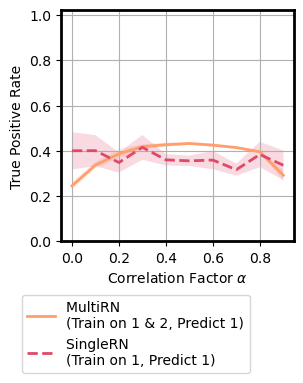

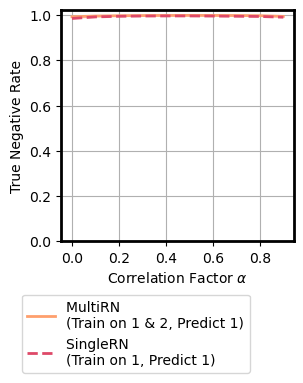

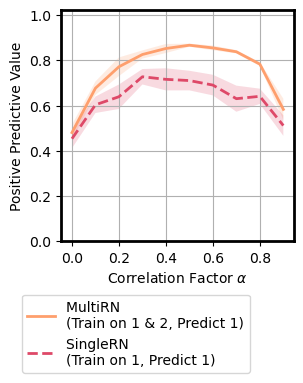

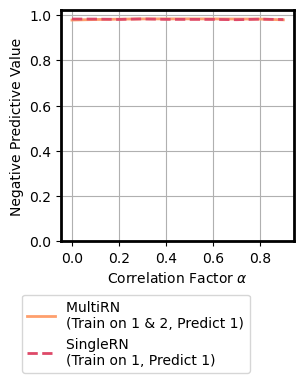

In [7]:
plot_threshold_dependent_metrics_with_confidence_intervals(multilabel_hybrid, quantile_threshold=0.985)

#### Generate Extended Data Figure 2 with threshold = 3% 

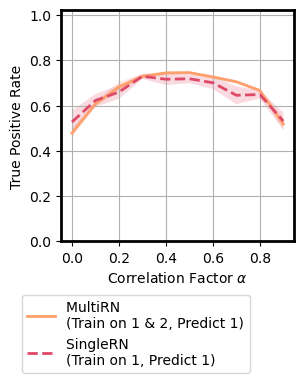

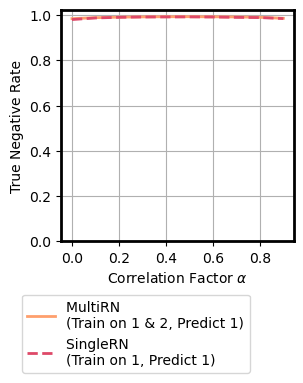

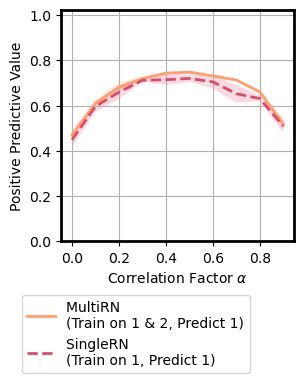

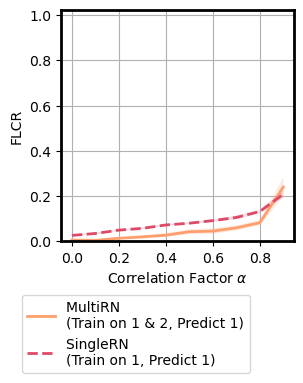

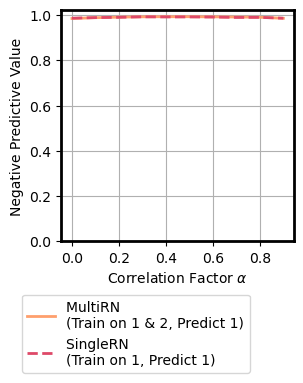

In [6]:
plot_threshold_dependent_metrics_with_confidence_intervals(multilabel_hybrid, quantile_threshold=0.97)

#### Generate Extended Data Figure 2 with threshold = 6% 

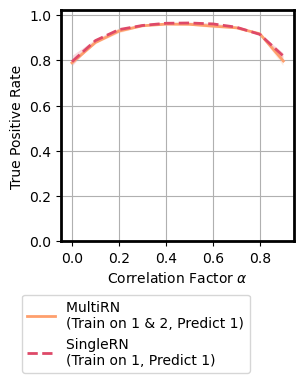

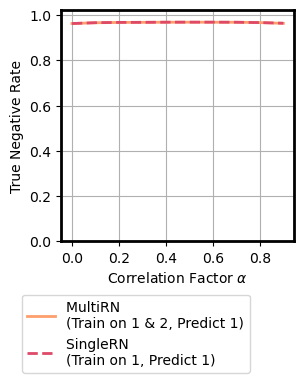

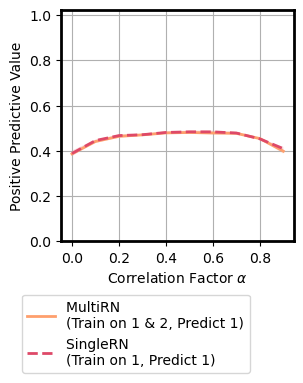

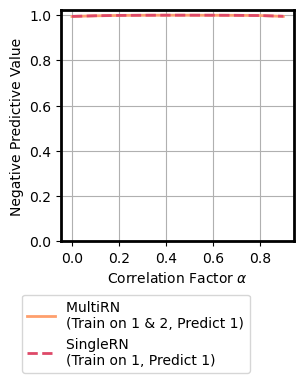

In [3]:
plot_threshold_dependent_metrics_with_confidence_intervals(multilabel_hybrid, quantile_threshold=0.94)

#### Generate Figure 1 plots for alpha = 0.7

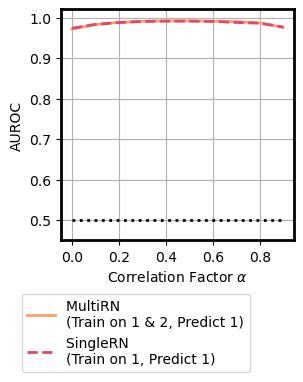

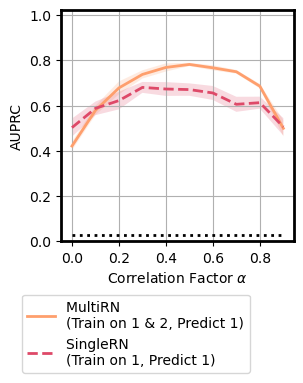

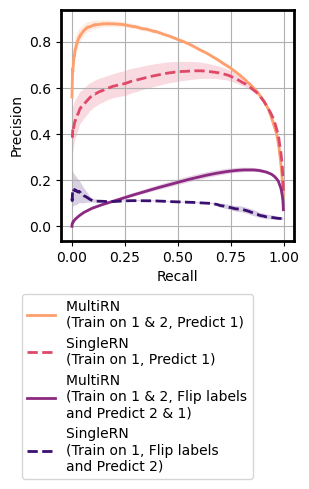

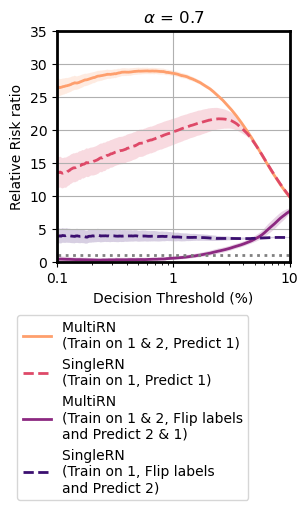

In [5]:
plot_figures_with_confidence_intervals( multilabel_hybrid, index=7)